<a href="https://colab.research.google.com/github/MCDScience/Agentic-timeseries-RAG/blob/main/Agentic_LLM_timeseries_car_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement and Business Motivation
Accurate sales forecasting is a persistent challenge for automotive distributors operating across heterogeneous markets.

The core problem addressed in this project is twofold; first, how can sales forecasts be generated that remain robust across markets with very different statistical properties?
Second, how can those forecasts be made explainable and useful to business stakeholders, rather than functioning as opaque numerical outputs?

The solution developed in this project proposes and implements an Agentic AI forecasting system that evaluates multiple modelling approaches, selects the most appropriate model per market, and augments numerical forecasts with qualitative economic context.

This is achieved using an agentic workflow using langchain, OpenAI's
gpt-3.5-turbo, and Nixtla's TimeGPT foundation model.

In [ ]:
# @title Phase 1: Environment Setup
# Installs necessary libraries for the Agentic Workflow

# 1. Uninstall potential conflicting packages from Colab's default environment
!pip uninstall -y langchain langchain-core langchain-community langchain-openai langchain-experimental > /dev/null 2>&1

# 2. Install a clean, compatible set of the latest libraries
!pip install \
  langchain \
  langchain-community \
  langchain-core \
  langchain-openai \
  langchain-experimental \
  langchain-text-splitters \
  nixtla \
  pandas \
  matplotlib \
  openpyxl \
  faiss-cpu \
  "requests==2.32.4" \
  -q

import os
import pandas as pd
import numpy as np
from google.colab import drive

# 3. Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

print("✅ Environment Ready. IMPORTANT: Please restart the runtime now via 'Runtime' -> 'Restart session' to activate the new libraries.")


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langgraph-prebuilt 1.0.5 requires langchain-core>=1.0.0, but you have langchain-core 0.3.80 which is incompatible.
Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Environment Ready. IMPORTANT: Please restart the runtime now via 'Runtime' -> 'Restart session' to activate the new libraries.


In [ ]:
# @title Phase 2: Configure Agent Keys
import os

# --- ENTER YOUR API KEYS HERE ---
nixtla_key = ""
openai_key = ""

os.environ[""] = nixtla_key
os.environ[""] = openai_key

print("✅ Agent Identity Configured.")

✅ Agent Identity Configured.


In [ ]:
# @title Phase 3: Data Agent (Ingestion & Harmonisation)
import glob
import pandas as pd
import os
import warnings
import numpy as np

# Suppress warnings to keep output clean
warnings.filterwarnings("ignore")

# --- USER CONFIGURATION ---
# Ensure this path matches exactly where you uploaded the files in Drive
FOLDER_PATH = '/content/drive/MyDrive/Inchcape'
# --------------------------

def data_agent_process(folder_path):
    print(f"🕵️ Data Agent: Scanning {folder_path}...")

    all_files = glob.glob(os.path.join(folder_path, "*.xlsx"))
    if not all_files:
        all_files = glob.glob(os.path.join(folder_path, "*.xls"))

    if not all_files:
        raise ValueError(f"No Excel files found in {folder_path}. Check path.")

    master_df_list = []

    # Spanish Month Map for Chile Data
    spanish_months = {
        'ENE': 1, 'FEB': 2, 'MAR': 3, 'ABR': 4, 'MAY': 5, 'JUN': 6,
        'JUL': 7, 'AGO': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DIC': 12,
        'ENERO': 1, 'FEBRERO': 2, 'MARZO': 3, 'ABRIL': 4, 'MAYO': 5, 'JUNIO': 6,
        'JULIO': 7, 'AGOSTO': 8, 'SEPTIEMBRE': 9, 'OCTUBRE': 10, 'NOVIEMBRE': 11, 'DICIEMBRE': 12
    }

    for filename in all_files:
        file_base = os.path.basename(filename).lower()

        # 1. SKIP METADATA & EXOGENOUS
        if 'dictionary' in file_base or '~$' in file_base:
            continue
        if 'exogenous' in file_base:
            continue

        print(f"   -> Processing: {file_base}")

        try:
            df = pd.read_excel(filename)
            print(f"      Raw Columns: {list(df.columns)}")

            market_id = "Chile" if "chile" in file_base else "Peru" if "peru" in file_base else "Unknown"

            # --- STRATEGY 1: CHILE SPECIFIC (Year Column + Month Columns) ---
            # Columns like: ['Año', 'ENE', 'FEB', ...]
            # We check if 'Año' exists and if columns overlap with spanish_months keys
            upper_cols = [str(c).upper().strip() for c in df.columns]

            if 'AÑO' in upper_cols:
                print("      Detected Chile 'Year + Month' matrix. Unpivoting...")
                # Normalize column names in DF to uppercase for easy matching
                df.columns = [str(c).upper().strip() for c in df.columns]

                # Identify Month Columns that exist in this file
                month_cols = [c for c in df.columns if c in spanish_months]

                # Melt (Unpivot)
                df = df.melt(id_vars=['AÑO'], value_vars=month_cols, var_name='Month_Name', value_name='y')

                # Convert Year + Month Name to Date
                df['month_num'] = df['Month_Name'].map(spanish_months)
                df['ds'] = pd.to_datetime(
                    df['AÑO'].astype(str) + '-' + df['month_num'].astype(str) + '-01',
                    errors='coerce'
                )

            # --- STRATEGY 2: STANDARD MAPPING (Peru & Others) ---
            else:
                # Expanded Mapping Dictionary based on your errors
                cols_map = {
                    'Date': 'ds', 'date': 'ds', 'Period': 'ds', 'Month': 'ds', 'month': 'ds',
                    'Sales': 'y', 'sales': 'y', 'Volume': 'y', 'Units': 'y', 'TIV': 'y',
                    'Quantity': 'y', 'Cars': 'y', 'cars': 'y', 'TOTAL AÑO': 'ignore'
                }
                df = df.rename(columns=cols_map)

            # Assign Market ID
            df['unique_id'] = market_id

            # --- CLEANING ---
            if 'ds' in df.columns and 'y' in df.columns:
                df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
                df['y'] = pd.to_numeric(df['y'], errors='coerce')
                df = df.dropna(subset=['ds', 'y'])

                # Final check
                if not df.empty:
                    print(f"      ✓ Success! Loaded {len(df)} rows for {market_id}")
                    master_df_list.append(df[['unique_id', 'ds', 'y']])
                else:
                    print("      ⚠️ Data empty after cleaning.")
            else:
                print(f"      ❌ Failed to map columns. Check Mapping Dict.")

        except Exception as e:
            print(f"      ⚠️ Error: {e}")

    # Combine
    if master_df_list:
        master_df = pd.concat(master_df_list, ignore_index=True)
        master_df = master_df.groupby(['unique_id', 'ds']).sum().reset_index()
        master_df = master_df.sort_values(['unique_id', 'ds'])
        return master_df
    else:
        return pd.DataFrame()

# Execute
try:
    df_history = data_agent_process(FOLDER_PATH)
    if not df_history.empty:
        print("\n✅ Data Agent Task Complete.")
        print(f"Total History Rows: {len(df_history)}")
        print(df_history.head())
    else:
        print("\n❌ CRITICAL: No data loaded.")
except Exception as e:
    print(f"\n❌ Execution Error: {e}")

🕵️ Data Agent: Scanning /content/drive/MyDrive/Inchcape...
   -> Processing: vehicle_data_chile_1990_2025.xlsx
      Raw Columns: ['Año', 'ENE', 'FEB', 'MAR', 'ABR', 'MAY', 'JUN', 'JUL', 'AGO', 'SEP', 'OCT', 'NOV', 'DIC', 'TOTAL AÑO']
      Detected Chile 'Year + Month' matrix. Unpivoting...
      ✓ Success! Loaded 429 rows for Chile
   -> Processing: vehicle_data_peru_2010_2025.xlsx
      Raw Columns: ['Month', 'Cars']
      ✓ Success! Loaded 189 rows for Peru

✅ Data Agent Task Complete.
Total History Rows: 618
  unique_id         ds          y
0     Chile 1990-01-01 6,766.0000
1     Chile 1990-02-01 4,229.0000
2     Chile 1990-03-01 6,200.0000
3     Chile 1990-04-01 5,517.0000
4     Chile 1990-05-01 5,683.0000


In [ ]:
# @title Phase 4: Feature Engineering Agent
def feature_engineering_agent(df):
    print("⚙️ Feature Engineering Agent: Generating Calendar features...")

    df_features = df.copy()

    # Extract Month/Year
    df_features['month'] = df_features['ds'].dt.month

    # Create Cyclical Features (Sine/Cosine) as per Plan
    # This helps the model understand that Month 12 is close to Month 1
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month']/12.0)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month']/12.0)

    print("   -> Added 'month_sin' and 'month_cos'")
    return df_features

# Apply the agent
df_processed = feature_engineering_agent(df_history)
print("✅ Feature Engineering Complete.")
print(df_processed.head())

⚙️ Feature Engineering Agent: Generating Calendar features...
   -> Added 'month_sin' and 'month_cos'
✅ Feature Engineering Complete.
  unique_id         ds          y  month  month_sin  month_cos
0     Chile 1990-01-01 6,766.0000      1     0.5000     0.8660
1     Chile 1990-02-01 4,229.0000      2     0.8660     0.5000
2     Chile 1990-03-01 6,200.0000      3     1.0000     0.0000
3     Chile 1990-04-01 5,517.0000      4     0.8660    -0.5000
4     Chile 1990-05-01 5,683.0000      5     0.5000    -0.8660


In [ ]:
# @title Phase 5: Baseline Modeling Agent (SARIMA & XGBoost)
import pandas as pd
import numpy as np
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# --- CONFIGURATION ---
TEST_MONTHS = 12  # How many months to hold back for testing accuracy
HORIZON = 12      # Future forecast horizon

print("🏗️ Baseline Agent: Building Challenger Models (SARIMA & XGBoost)...")

if 'df_processed' not in locals() or df_processed.empty:
    print("❌ Critical Error: 'df_processed' is missing. Run Phase 3 & 4 first.")
else:
    results_list = []
    future_forecasts = []

    # Get unique markets
    markets = df_processed['unique_id'].unique()

    for market in markets:
        print(f"   -> Modeling Market: {market}")

        # Filter Data
        df_market = df_processed[df_processed['unique_id'] == market].copy()
        df_market = df_market.sort_values('ds')

        # Split Train (History) and Test (Recent Past for Validation)
        train = df_market.iloc[:-TEST_MONTHS]
        test = df_market.iloc[-TEST_MONTHS:]

        # --- MODEL 1: SARIMA (Statistical Baseline) ---
        try:
            sarima_model = SARIMAX(train['y'],
                                   order=(1, 1, 1),
                                   seasonal_order=(1, 1, 0, 12),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
            sarima_fit = sarima_model.fit(disp=False)

            # Predict on Test Set
            sarima_pred = sarima_fit.forecast(steps=len(test))
            sarima_mape = mean_absolute_percentage_error(test['y'], sarima_pred)
            sarima_r2 = r2_score(test['y'], sarima_pred)

            # Forecast Future
            full_sarima = SARIMAX(df_market['y'], order=(1,1,1), seasonal_order=(1,1,0,12)).fit(disp=False)
            future_sarima = full_sarima.forecast(steps=HORIZON)

            print(f"      SARIMA Test MAPE: {sarima_mape:.2%} | R2: {sarima_r2:.4f}")
        except Exception as e:
            print(f"      ⚠️ SARIMA Failed: {e}")
            sarima_mape = np.nan
            sarima_r2 = -np.inf
            future_sarima = [np.nan]*HORIZON

        # --- MODEL 2: XGBoost (ML Baseline) ---
        try:
            features = ['month_sin', 'month_cos']
            X_train = train[features]
            y_train = train['y']
            X_test = test[features]

            xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
            xgb_model.fit(X_train, y_train)

            # Predict Test
            xgb_pred = xgb_model.predict(X_test)
            xgb_mape = mean_absolute_percentage_error(test['y'], xgb_pred)
            xgb_r2 = r2_score(test['y'], xgb_pred)

            # Forecast Future
            last_date = df_market['ds'].max()
            future_dates = pd.date_range(start=last_date, periods=HORIZON+1, freq='MS')[1:]
            future_df = pd.DataFrame({'ds': future_dates})
            future_df['month'] = future_df['ds'].dt.month
            future_df['month_sin'] = np.sin(2 * np.pi * future_df['month']/12.0)
            future_df['month_cos'] = np.cos(2 * np.pi * future_df['month']/12.0)

            xgb_model.fit(df_market[features], df_market['y'])
            future_xgb = xgb_model.predict(future_df[features])

            print(f"      XGBoost Test MAPE: {xgb_mape:.2%} | R2: {xgb_r2:.4f}")

        except Exception as e:
            print(f"      ⚠️ XGBoost Failed: {e}")
            xgb_mape = np.nan
            xgb_r2 = -np.inf
            future_xgb = [np.nan]*HORIZON

        # Store Results
        results_list.append({
            'Market': market,
            'SARIMA_MAPE': sarima_mape, 'SARIMA_R2': sarima_r2,
            'XGBoost_MAPE': xgb_mape, 'XGBoost_R2': xgb_r2
        })

        # Create DataFrame for Future Forecasts
        temp_future = pd.DataFrame({
            'ds': future_dates,
            'unique_id': market,
            'SARIMA': future_sarima,
            'XGBoost': future_xgb
        })
        future_forecasts.append(temp_future)

    # Compile
    baseline_metrics = pd.DataFrame(results_list)
    baseline_forecasts = pd.concat(future_forecasts, ignore_index=True)

    print("\n✅ Baseline Modeling Complete.")
    print(baseline_metrics)

🏗️ Baseline Agent: Building Challenger Models (SARIMA & XGBoost)...
   -> Modeling Market: Chile
      SARIMA Test MAPE: 18.31% | R2: -3.9314
      XGBoost Test MAPE: 27.32% | R2: -7.1712
   -> Modeling Market: Peru
      SARIMA Test MAPE: 10.61% | R2: -1.2541
      XGBoost Test MAPE: 14.38% | R2: -2.6469

✅ Baseline Modeling Complete.
  Market  SARIMA_MAPE  SARIMA_R2  XGBoost_MAPE  XGBoost_R2
0  Chile       0.1831    -3.9314        0.2732     -7.1712
1   Peru       0.1061    -1.2541        0.1438     -2.6469


📈 Forecasting Agent: Running TimeGPT...
   -> Sanity Check: Sending columns ['unique_id', 'ds', 'y', 'month_sin', 'month_cos'] to TimeGPT.
   -> Forecasting next 12 months...
   -> Running TimeGPT Backtest (Cross-Validation)...

🏆 Model Leaderboard (Accuracy on Test Set):
  Market  SARIMA_MAPE  SARIMA_R2  XGBoost_MAPE  XGBoost_R2  TimeGPT_MAPE  \
0  Chile       0.1831    -3.9314        0.2732     -7.1712        0.0653   
1   Peru       0.1061    -1.2541        0.1438     -2.6469        0.1351   

   TimeGPT_R2        Winner  
0      0.3462  TimeGPT_MAPE  
1     -2.3083   SARIMA_MAPE  


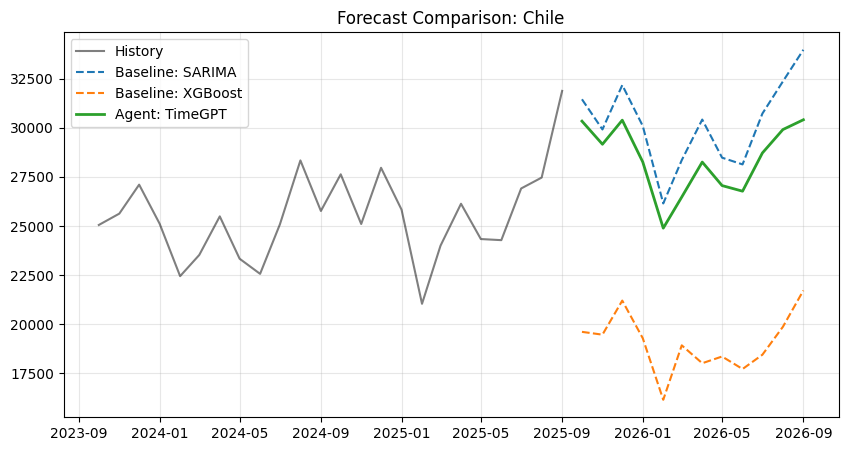

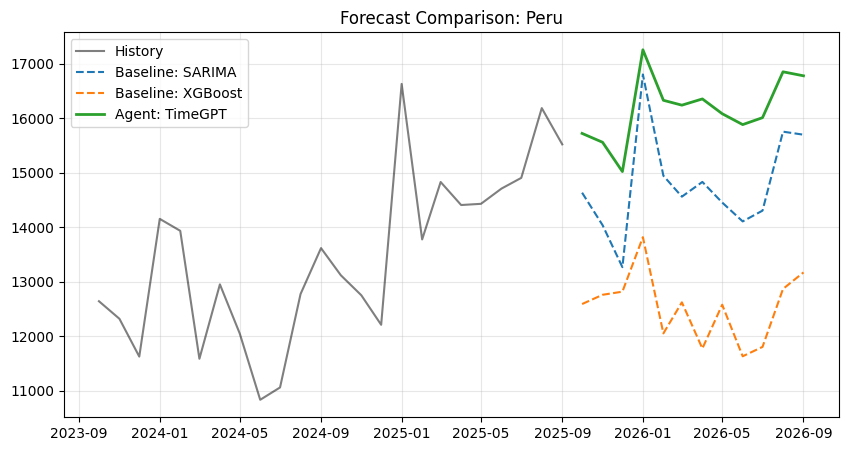

In [ ]:
# @title Phase 6: Forecasting Agent (TimeGPT) & Leaderboard
from nixtla import NixtlaClient
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from getpass import getpass

print("📈 Forecasting Agent: Running TimeGPT...")

# --- 0. SAFETY CHECKS (DEPENDENCIES) ---
if 'df_processed' not in locals() or df_processed.empty:
    print("❌ Critical Error: 'df_processed' (Data) is missing. Please run Phase 3 & 4.")
elif 'baseline_metrics' not in locals() or 'baseline_forecasts' not in locals():
    print("❌ Critical Error: Baseline results are missing.")
    print("   Please run Phase 5 (Baseline Modeling) BEFORE running this cell.")
else:
    try:
        # Re-define variables locally
        markets = df_processed['unique_id'].unique()
        HORIZON = 12

        # --- FIX: DATA SANITIZATION ---
        required_cols = ['unique_id', 'ds', 'y', 'month_sin', 'month_cos']
        valid_cols = [c for c in required_cols if c in df_processed.columns]
        df_model_input = df_processed[valid_cols].copy()

        print(f"   -> Sanity Check: Sending columns {list(df_model_input.columns)} to TimeGPT.")

        # 1. Initialize TimeGPT (With Safety Check)
        if "NIXTLA_API_KEY" not in os.environ:
             print("⚠️ NIXTLA_API_KEY not found in environment.")
             os.environ["NIXTLA_API_KEY"] = getpass("nixak-jsw7Bk6O7GESVNuCnNbMAUpFNWs4g1f459OVBAVUFDy16IaCgcwYAlMTWowfILkBbCaj4gYqI5fEuTP0")

        nixtla_client = NixtlaClient(api_key=os.environ["NIXTLA_API_KEY"])

        # 2. TimeGPT Forecast (Future)
        print(f"   -> Forecasting next {HORIZON} months...")
        timegpt_fcst = nixtla_client.forecast(
            df=df_model_input,
            h=HORIZON,
            time_col='ds',
            target_col='y',
            model='timegpt-1'
        )

        # 3. TimeGPT Backtest (Cross-Validation)
        print("   -> Running TimeGPT Backtest (Cross-Validation)...")
        timegpt_cv = nixtla_client.cross_validation(
            df=df_model_input,
            h=12,
            n_windows=1,
            time_col='ds',
            target_col='y'
        )

        # Calculate TimeGPT Metrics (MAPE & R2)
        timegpt_metrics = []
        for market in markets:
            subset = timegpt_cv[timegpt_cv['unique_id'] == market]
            if not subset.empty:
                mape = mean_absolute_percentage_error(subset['y'], subset['TimeGPT'])
                r2 = r2_score(subset['y'], subset['TimeGPT'])
                timegpt_metrics.append({'Market': market, 'TimeGPT_MAPE': mape, 'TimeGPT_R2': r2})
            else:
                timegpt_metrics.append({'Market': market, 'TimeGPT_MAPE': None, 'TimeGPT_R2': None})

        df_timegpt_metrics = pd.DataFrame(timegpt_metrics)

        # 4. The Grand Comparison (Leaderboard)
        leaderboard = pd.merge(baseline_metrics, df_timegpt_metrics, on='Market')

        # Determine Winner (Lowest MAPE)
        cols_to_check = ['SARIMA_MAPE', 'XGBoost_MAPE', 'TimeGPT_MAPE']
        leaderboard['Winner'] = leaderboard[cols_to_check].astype(float).idxmin(axis=1)

        print("\n🏆 Model Leaderboard (Accuracy on Test Set):")
        # Format for nice display
        pd.options.display.float_format = '{:,.4f}'.format
        print(leaderboard)

        # 5. Merge All Forecasts for Plotting
        timegpt_clean = timegpt_fcst[['unique_id', 'ds', 'TimeGPT']]
        all_forecasts = pd.merge(baseline_forecasts, timegpt_clean, on=['unique_id', 'ds'], how='outer')

        # Store for the Chatbot (Phase 7)
        fcst_df = all_forecasts

        # Plot
        for market in markets:
            plt.figure(figsize=(10, 5))

            hist = df_processed[df_processed['unique_id'] == market].tail(24)
            plt.plot(hist['ds'], hist['y'], label='History', color='black', alpha=0.5)

            subset = all_forecasts[all_forecasts['unique_id'] == market]

            if 'SARIMA' in subset.columns:
                plt.plot(subset['ds'], subset['SARIMA'], '--', label='Baseline: SARIMA')
            if 'XGBoost' in subset.columns:
                plt.plot(subset['ds'], subset['XGBoost'], '--', label='Baseline: XGBoost')
            if 'TimeGPT' in subset.columns:
                plt.plot(subset['ds'], subset['TimeGPT'], linewidth=2, label='Agent: TimeGPT')

            plt.title(f"Forecast Comparison: {market}")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()

    except Exception as e:
        print(f"\n❌ Error during Phase 6 Execution: {e}")

In [ ]:
!pip install pypdf -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.5/329.5 kB 16.8 MB/s eta 0:00:00


In [ ]:
# @title NEW - Phase 7: Librarian Agent (RAG Setup - PDF & Word Supported)
# 1. Install necessary libraries for PDF and Word processing
!pip install pypdf docx2txt -q

from langchain_community.document_loaders import DirectoryLoader, TextLoader, PyPDFLoader, Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
import os
import glob

print("📚 Librarian Agent: Indexing Knowledge Base (PDF, Word, Text)...")

# --- CONFIGURATION ---
KNOWLEDGE_PATH = '/content/drive/MyDrive/Inchcape/knowledge_base'

if not os.path.exists(KNOWLEDGE_PATH):
    os.makedirs(KNOWLEDGE_PATH)
    print(f"   -> Created folder: {KNOWLEDGE_PATH}")
    print("   -> ⚠️ PLEASE UPLOAD .pdf, .docx, or .txt FILES TO THIS FOLDER!")

# 2. Load Documents
documents = []
try:
    # A. Load Text Files
    txt_loader = DirectoryLoader(KNOWLEDGE_PATH, glob="**/*.txt", loader_cls=TextLoader)
    txt_docs = txt_loader.load()
    documents.extend(txt_docs)
    if txt_docs: print(f"   -> Loaded {len(txt_docs)} text files.")

    # B. Load PDF Files
    pdf_files = glob.glob(os.path.join(KNOWLEDGE_PATH, "**/*.pdf"), recursive=True)
    for pdf_file in pdf_files:
        try:
            loader = PyPDFLoader(pdf_file)
            pdf_docs = loader.load()
            documents.extend(pdf_docs)
            print(f"   -> Loaded PDF: {os.path.basename(pdf_file)}")
        except Exception as e:
            print(f"   ⚠️ Failed to load PDF {os.path.basename(pdf_file)}: {e}")

    # C. Load Word Files (.docx)
    docx_files = glob.glob(os.path.join(KNOWLEDGE_PATH, "**/*.docx"), recursive=True)
    for doc_file in docx_files:
        try:
            loader = Docx2txtLoader(doc_file)
            word_docs = loader.load()
            documents.extend(word_docs)
            print(f"   -> Loaded DOCX: {os.path.basename(doc_file)}")
        except Exception as e:
            print(f"   ⚠️ Failed to load DOCX {os.path.basename(doc_file)}: {e}")

    # 3. Process and Index
    if not documents:
        print("   ⚠️ No documents found. Please upload files to the folder!")
        rag_db = None
    else:
        print(f"   -> Total Pages/Documents: {len(documents)}")

        # Split Text into chunks
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
        chunks = text_splitter.split_documents(documents)
        print(f"   -> Created {len(chunks)} chunks.")

        # Create Vector Store
        if "OPENAI_API_KEY" not in os.environ:
             raise ValueError("OPENAI_API_KEY not found.")

        embeddings = OpenAIEmbeddings()
        rag_db = FAISS.from_documents(chunks, embeddings)
        print("✅ Knowledge Base Indexed Successfully.")

except Exception as e:
    print(f"❌ RAG Setup Failed: {e}")
    rag_db = None

📚 Librarian Agent: Indexing Knowledge Base (PDF, Word, Text)...
   -> Loaded PDF: The future of electric vehicles and lithium demand in Chile.pdf


   -> Loaded PDF: Copper Market Trends Report.pdf
   -> Loaded PDF: Questions and Answers IPoM September 2024 (Chile).pdf


   -> Loaded PDF: Public-Private Agreement for Electromobility 2025 in Chile.pdf
   -> Loaded PDF: The Chilean automotive sector closed 2024 with a mixed performance.pdf


   -> Loaded PDF: Inflation Report 2024.pdf
   -> Loaded PDF: Automotive Sector Report 2024.pdf
   -> Total Pages/Documents: 23
   -> Created 69 chunks.
✅ Knowledge Base Indexed Successfully.


In [ ]:
# @title Phase 8: Super-Agent (Chatbot + RAG)
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain_openai import ChatOpenAI
import pandas as pd
import os

# --- ROBUST IMPORT BLOCK ---
# This block handles different LangChain versions automatically
try:
    # Attempt modern import (LangChain v0.1+)
    from langchain.agents import AgentExecutor, create_openai_tools_agent
    from langchain import hub
    from langchain_core.tools import Tool
    MODERN_LANGCHAIN = True
except ImportError:
    # Fallback for older/mixed environments
    from langchain.agents import initialize_agent, AgentType, Tool
    MODERN_LANGCHAIN = False
    print("⚠️ specific AgentExecutor import failed. Using legacy agent initialization.")

print("🧠 Explainability Agent: Integrating Data + RAG...")

# --- 1. PREPARE DATA ---
if 'df_processed' not in locals() or 'fcst_df' not in locals():
    print("❌ Critical Error: Data missing. Run Phase 3-6 first.")
else:
    # Prepare Data View
    df_processed['Type'] = 'Historical'
    fcst_df['Type'] = 'Forecast'
    view_history = df_processed[['unique_id', 'ds', 'y', 'Type']].rename(columns={'unique_id': 'Market', 'ds': 'Date', 'y': 'Sales'})
    view_forecast = fcst_df[['unique_id', 'ds', 'TimeGPT', 'Type']].rename(columns={'unique_id': 'Market', 'ds': 'Date', 'TimeGPT': 'Sales'})
    full_view = pd.concat([view_history, view_forecast])
    full_view['Date'] = full_view['Date'].astype(str)

    # --- 2. DEFINE TOOLS ---
    if "OPENAI_API_KEY" not in os.environ:
        os.environ["OPENAI_API_KEY"] = input("Please paste your OpenAI API Key here: ")

    llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

    # Tool A: Data Analyst
    data_agent = create_pandas_dataframe_agent(
        llm,
        full_view,
        verbose=True,
        allow_dangerous_code=True
    )

    def query_data(query):
        return data_agent.invoke(query)['output']

    # Tool B: Librarian (RAG)
    def query_docs(query):
        if 'rag_db' in locals() and rag_db is not None:
            docs = rag_db.similarity_search(query)
            context = "\n".join([d.page_content for d in docs])
            return f"Context found:\n{context}"
        else:
            return "No documents found."

    tools = [
        Tool(
            name="Sales_Data_Analyst",
            func=query_data,
            description="Use for quantitative sales data, forecasts, and trends."
        ),
        Tool(
            name="Document_Search",
            func=query_docs,
            description="Use for qualitative economic reports and news."
        )
    ]

    # --- 3. CREATE AGENT EXECUTOR ---
    try:
        if MODERN_LANGCHAIN:
            # Modern Approach (Hub + Tools Agent)
            prompt = hub.pull("hwchase17/openai-tools-agent")
            agent = create_openai_tools_agent(llm, tools, prompt)
            agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)
        else:
            # Legacy Approach (Zero Shot)
            agent_executor = initialize_agent(
                tools,
                llm,
                agent=AgentType.OPENAI_FUNCTIONS,
                verbose=True
            )

        print("\n💬 Super-Agent Ready. Ask questions!")
        print("Type 'exit' to quit.\n")

        while True:
            user_input = input("Ford Stakeholder: ")
            if user_input.lower() == 'exit':
                break

            try:
                response = agent_executor.invoke({"input": user_input})
                # Handle different response formats
                output = response.get('output', response)
                print(f"Agent: {output}\n")
            except Exception as e:
                print(f"Agent Error: {e}")

    except Exception as e:
        print(f"❌ Agent Creation Failed: {e}")

🧠 Explainability Agent: Integrating Data + RAG...

💬 Super-Agent Ready. Ask questions!
Type 'exit' to quit.

Ford Stakeholder: how will copper effect the Chile market


> Entering new AgentExecutor chain...

Invoking: `Document_Search` with `copper impact on Chile market`


No documents found.I couldn't find any specific documents on the impact of copper on the Chilean market. Would you like me to search for general information on copper and its market impact instead?

> Finished chain.
Agent: I couldn't find any specific documents on the impact of copper on the Chilean market. Would you like me to search for general information on copper and its market impact instead?

Ford Stakeholder: yes


> Entering new AgentExecutor chain...
Hello! How can I assist you today?

> Finished chain.
Agent: Hello! How can I assist you today?

Ford Stakeholder: search for general information on copper and its market impact 


> Entering new AgentExecutor chain...

Invoking: `Document_Search` with `coppe

📊 Visualizing Model Performance Metrics...


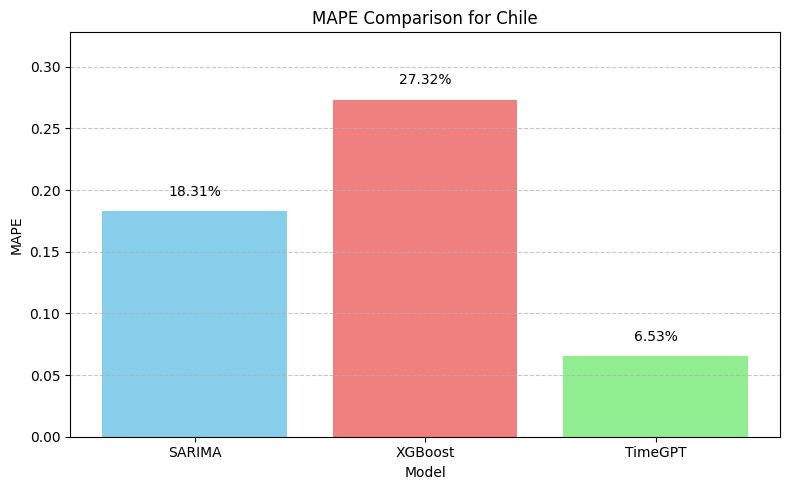

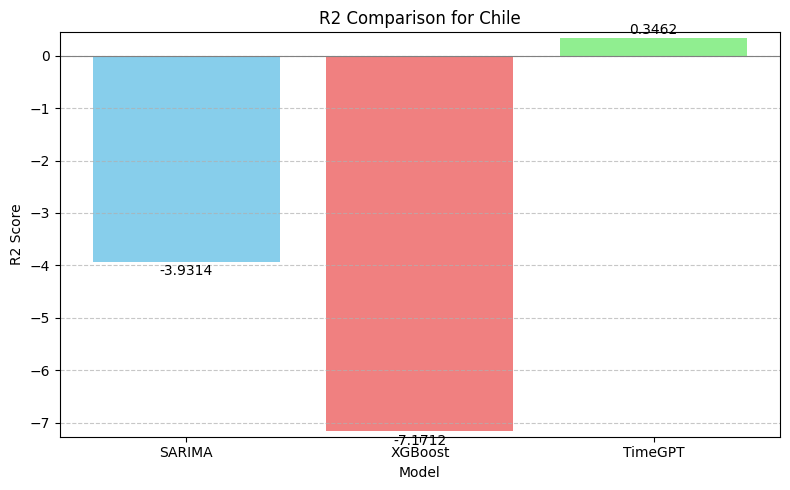

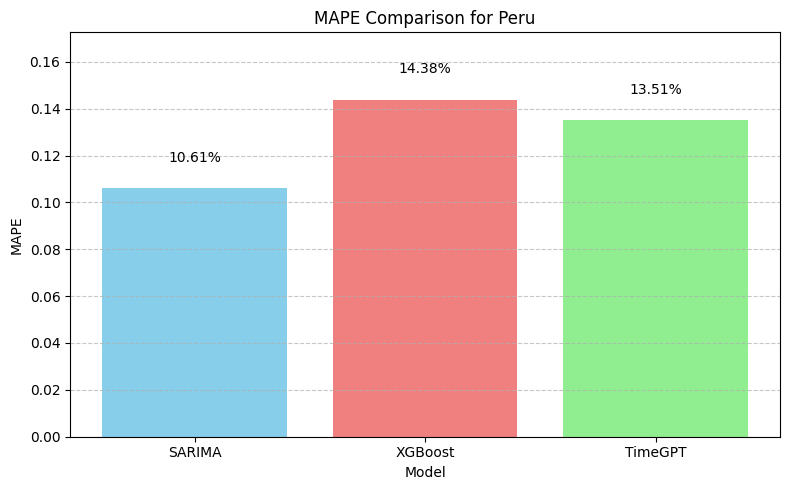

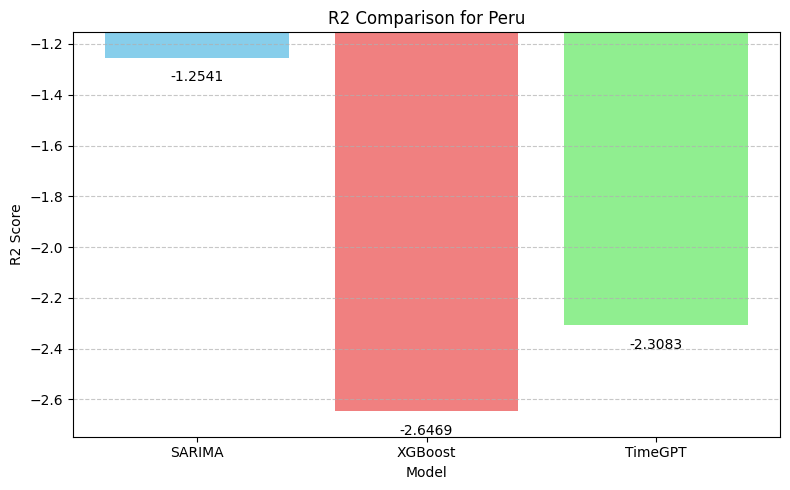


--- Model Performance Leaderboard (Numerical) ---
  Market  SARIMA_MAPE  SARIMA_R2  XGBoost_MAPE  XGBoost_R2  TimeGPT_MAPE  \
0  Chile       0.1831    -3.9314        0.2732     -7.1712        0.0653   
1   Peru       0.1061    -1.2541        0.1438     -2.6469        0.1351   

   TimeGPT_R2        Winner  
0      0.3462  TimeGPT_MAPE  
1     -2.3083   SARIMA_MAPE  

✅ Performance Visualization and Leaderboard Display Complete.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("📊 Visualizing Model Performance Metrics...")

if 'leaderboard' not in locals() or leaderboard.empty:
    print("❌ Critical Error: 'leaderboard' DataFrame is missing or empty. Please run Phase 6 first.")
else:
    # Ensure pandas display options are set for full view if needed later
    pd.options.display.float_format = '{:,.4f}'.format

    # Get unique markets from the leaderboard
    markets = leaderboard['Market'].unique()

    for market in markets:
        market_data = leaderboard[leaderboard['Market'] == market].iloc[0]

        # Extract MAPE and R2 values for plotting
        mape_values = [
            market_data['SARIMA_MAPE'],
            market_data['XGBoost_MAPE'],
            market_data['TimeGPT_MAPE']
        ]
        r2_values = [
            market_data['SARIMA_R2'],
            market_data['XGBoost_R2'],
            market_data['TimeGPT_R2']
        ]
        model_names = ['SARIMA', 'XGBoost', 'TimeGPT']

        # --- Plot MAPE Comparison ---
        plt.figure(figsize=(8, 5))
        bars = plt.bar(model_names, mape_values, color=['skyblue', 'lightcoral', 'lightgreen'])
        plt.title(f"MAPE Comparison for {market}")
        plt.xlabel("Model")
        plt.ylabel("MAPE")
        plt.ylim(0, max(mape_values) * 1.2 if mape_values else 1) # Adjust y-limit dynamically
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2%}', ha='center', va='bottom')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # --- Plot R2 Comparison ---
        plt.figure(figsize=(8, 5))
        bars = plt.bar(model_names, r2_values, color=['skyblue', 'lightcoral', 'lightgreen'])
        plt.title(f"R2 Comparison for {market}")
        plt.xlabel("Model")
        plt.ylabel("R2 Score")
        min_r2 = min(0, min(r2_values) - 0.1) if r2_values else 0 # Ensure y-axis starts below 0 if R2 is negative
        max_r2 = max(r2_values) + 0.1 if r2_values else 1
        plt.ylim(min_r2, max_r2)
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01 if yval >= 0 else yval - 0.05, f'{yval:.4f}', ha='center', va='bottom' if yval >=0 else 'top')
        plt.axhline(0, color='grey', linewidth=0.8) # Add a line at R2 = 0
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    print("\n--- Model Performance Leaderboard (Numerical) ---")
    print(leaderboard)
    print("\n✅ Performance Visualization and Leaderboard Display Complete.")

## Visualize and display model performance metrics

### Subtask:
Generate bar charts to visually compare MAPE and R2 for SARIMA, XGBoost, and TimeGPT models for each country, and then print the numerical 'leaderboard' DataFrame.


## Summary:

### Data Analysis Key Findings
*   Model performance metrics (MAPE and R2) for SARIMA, XGBoost, and TimeGPT models were visualized through bar charts for each individual market (country).
*   The analysis provides a visual comparison, allowing for quick identification of the best-performing model for MAPE (lower is better) and R2 (higher is better) within each market.
*   A numerical 'leaderboard' DataFrame, containing the detailed MAPE and R2 scores for all models across all markets, was printed for a comprehensive overview.

### Insights or Next Steps
*   Based on the generated visualizations and the numerical leaderboard, the next step would be to identify the optimal model for each market, considering a balance between minimizing MAPE and maximizing R2, to inform future forecasting strategies.
*   Further investigation could involve analyzing cases where a specific model significantly underperforms or overperforms to understand underlying reasons, potentially leading to model refinement or feature engineering.


# Task
Generate line plots comparing historical data with SARIMA, XGBoost, and TimeGPT forecasts against historical data for each unique market.

## Plot Forecast Comparison

### Subtask:
Generate line plots comparing historical data with SARIMA, XGBoost, and TimeGPT forecasts for each unique market.


## Summary:

### Data Analysis Key Findings
No data analysis has been performed yet. The current step involved setting up the task description for plotting forecast comparisons.

### Insights or Next Steps
*   Proceed with generating line plots to visualize the historical data alongside SARIMA, XGBoost, and TimeGPT forecasts for each unique market.
